In [1]:
#!/usr/bin/env python
# coding: utf-8

import os, sys
import logging

import numpy as np
import h5netcdf

import xarray as xr
import xarray.ufuncs as xu
import xrft
import pandas as pd
from scipy.signal import convolve2d, detrend

from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy

plt.rc("figure", figsize=(12,10))
plt.rc("font", size=14)

from dask.distributed import Client, LocalCluster
#
# Initialisation d'un cluster de 32 coeurs
cluster = LocalCluster(processes=False, n_workers=1, threads_per_worker=4, silence_logs='error')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://137.129.155.67:8787/status,
Dashboard: http://137.129.155.67:8787/status,Workers: 1
Total threads: 4,Total memory: 78.61 GiB
Status: running,Using processes: False
Comm: inproc://137.129.155.67/15111/1,Workers: 1
Dashboard: http://137.129.155.67:8787/status,Total threads: 4
Started: Just now,Total memory: 78.61 GiB
Comm: inproc://137.129.155.67/15111/4,Total threads: 4
Dashboard: http://137.129.155.67:48325/status,Memory: 78.61 GiB
Nanny: None,


In [2]:
path = "/home/durand/Documents/OLR/"
# path = ""

indir_data = path + 'Anomaly/'
outdir_TF = path + 'TF2D/'

indir_data = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/RAW_ANOMALY/OLR/'
outdir_TF = '/cnrm/tropics/commun/DATACOMMUN/WAVE/NO_SAVE/DATA/TF2D/OLR/'

var = 'OLR'
prefix = 'TF2D'

addDay = 180
spd = 1

In [3]:
def createArray(year) :
    if year != 2014 :
        _ds_m1 = xr.open_mfdataset(indir_data+'*'+var+'*'+str(y-1)+'*.nc', chunks = { 'time' : 1, 'lat' : 1}, parallel=True)
        _ds_m1 = _ds_m1.isel(time = slice(-addDay*int(24/3),None))
    else:
        _ds_m1 = xr.open_mfdataset(indir_data+'*'+var+'*'+str(y-1)+'_2*.nc', chunks = { 'time' : 1, 'lat' : 1}, parallel=True)
        _ds_m1 = _ds_m1.isel(time = slice(-(28+31+30+31)*int(24/3),None))
    _ds = xr.open_mfdataset(indir_data+'*'+var+'*'+str(y)+'*.nc', chunks = { 'time' : 1, 'lat' : 1, 'longitude' : 10}, parallel=True)
    _ds1 = xr.open_mfdataset(indir_data+'*'+var+'*'+str(y+1)+'*.nc', chunks = { 'time' : 1, 'lat' : 1, 'longitude' : 10}, parallel=True)
    _ds1 = _ds1.isel(time = slice(None,addDay*int(24/3)))

    ds = xr.concat([_ds_m1,_ds,_ds1], dim='time', coords='minimal', compat='override')
    
    return ds

In [4]:
def split_hann_taper(series_length, fraction):
    """Implements `split cosine bell` taper of length series_length where only fraction of points are tapered (combined on both ends).
    
    This returns a function that tapers to zero on the ends. To taper to the mean of a series X:
    XTAPER = (X - X.mean())*series_taper + X.mean()
    """
    npts = int(np.rint(fraction * series_length))  # total size of taper
    taper = np.hanning(npts)
    series_taper = np.ones(series_length)
    series_taper[0:npts//2+1] = taper[0:npts//2+1]
    series_taper[-npts//2+1:] = taper[npts//2+1:]
    return series_taper, taper

def smooth_wavefreq(data, kern=None, nsmooth=None, freq_ax=None, freq_name=None):
    """Apply a convolution of (data,kern) nsmooth times.
       The convolution is applied separately to the positive and negative frequencies.
       Either the name (freq_name: str) or axis index (freq_ax: int) of frequency is required, with the name preferred.
    """
    assert isinstance(data, xr.DataArray)
    if kern is None:
        kern = simple_smooth_kernel()
    if nsmooth is None:
        nsmooth = 20
    if freq_name is not None:
        axnum = list(data.dims).index(freq_name)
        nzero =  data.sizes[freq_name] // 2 # <-- THIS IS SUPPOSED TO BE THE INDEX AT FREQ==0.0
    elif freq_ax is not None:
        axnum = freq_ax
        nzero = data.shape[freq_ax] // 2
    else:
        raise ValueError("smooth_wavefreq needs to know how to find frequency dimension.")
    smth1pass = convolvePosNeg(data, kern, axnum, nzero) # this is a custom function to skip 0-frequency (mean)
    # note: the convolution is strictly 2D and the boundary condition is symmetric --> if kernel is normalized, preserves the sum.
    smth1pass = xr.DataArray(smth1pass, dims=data.dims, coords=data.coords) # ~copy_metadata
    # repeat smoothing many times:
    smthNpass = smth1pass.values.copy()
    for i in range(nsmooth):
        smthNpass = convolvePosNeg(smthNpass, kern, axnum, nzero)
    return xr.DataArray(smthNpass, dims=data.dims, coords=data.coords)

def simple_smooth_kernel():
    """Provide a very simple smoothing kernel."""
    kern = np.array([[0, 1, 0],[1, 2, 1],[0, 1, 0]])
    return kern / kern.sum()

def convolvePosNeg(arr, k, dim, boundary_index):
    """Apply convolution of (arr, k) excluding data at boundary_index in dimension dim.
    
    arr: numpy ndarray of data
    k: numpy ndarray, same dimension as arr, this should be the kernel
    dim: integer indicating the axis of arr to split
    boundary_index: integer indicating the position to split dim
    
    Split array along dim at boundary_index;
    perform convolution on each sub-array;
    reconstruct output array from the two subarrays;
    the values of output at boundary_index of dim will be same as input.
    
    `convolve2d` is `scipy.signal.convolve2d()`
    """
    # arr: numpy ndarray
    oarr = arr.copy()  # maybe not good to make a fresh copy every time?
    # first pass is [0 : boundary_index)
    slc1 = [slice(None)] * arr.ndim
    slc1[dim] = slice(None, boundary_index)
    arr1 = arr[tuple(slc1)]
    ans1 = convolve2d(arr1, k, boundary='symm', mode='same')
    # second pass is [boundary_index+1, end]
    slc2 = [slice(None)] * arr.ndim
    slc2[dim] = slice(boundary_index+1,None)
    arr2 = arr[tuple(slc2)]
    ans2 = convolve2d(arr2, k, boundary='symm', mode='same')
    # fill in the output array
    oarr[tuple(slc1)] = ans1
    oarr[tuple(slc2)] = ans2
    return oarr

In [5]:
def  decompose2SymAsym(arr):
    """Mimic NCL function to decompose into symmetric and asymmetric parts.
    
    arr: xarra DataArray
    return: DataArray with symmetric in SH, asymmetric in NH
    Note:
        This function produces indistinguishable results from NCL version.
    """
#     lat_dim = arr.dims.index('lat')
#     print(lat_dim)
    # flag to follow NCL convention and put symmetric component in SH 
    # & asymmetric in NH
    # method: use flip to reverse latitude, put in DataArray for coords, use loc/isel
    # to assign to negative/positive latitudes (exact equator is left alone)
    _arr = arr.reindex(lat=arr.lat[::-1])
    _arr['lat'] = arr.lat
    data_sym = 0.5*(arr + _arr)
    data_asy = 0.5*(arr - _arr)
    data_sym = xr.DataArray(data_sym, dims=arr.dims, coords=arr.coords)
    data_asy = xr.DataArray(data_asy, dims=arr.dims, coords=arr.coords)
    out = arr.copy()  # might not be best to copy, but is safe        
    out.loc[{'lat':arr['lat'][arr['lat']<0]}] = data_sym.isel(lat=data_sym.lat<0)
    out.loc[{'lat':arr['lat'][arr['lat']>0]}] = data_asy.isel(lat=data_asy.lat>0)
    return out

def genDispersionCurves(nWaveType=6, nPlanetaryWave=50, rlat=0, Ahe=[50, 25, 12]):
    """
    Function to derive the shallow water dispersion curves. Closely follows NCL version.
    input:
        nWaveType : integer, number of wave types to do
        nPlanetaryWave: integer
        rlat: latitude in radians (just one latitude, usually 0.0)
        Ahe: [50.,25.,12.] equivalent depths
              ==> defines parameter: nEquivDepth ; integer, number of equivalent depths to do == len(Ahe)
    returns: tuple of size 2
        Afreq: Frequency, shape is (nWaveType, nEquivDepth, nPlanetaryWave)
        Apzwn: Zonal savenumber, shape is (nWaveType, nEquivDepth, nPlanetaryWave)
        
    notes:
        The outputs contain both symmetric and antisymmetric waves. In the case of 
        nWaveType == 6:
        0,1,2 are (ASYMMETRIC) "MRG", "IG", "EIG" (mixed rossby gravity, inertial gravity, equatorial inertial gravity)
        3,4,5 are (SYMMETRIC) "Kelvin", "ER", "IG" (Kelvin, equatorial rossby, inertial gravity)
    """
    nEquivDepth = len(Ahe) # this was an input originally, but I don't know why.
    pi    = np.pi
    radius = 6.37122e06    # [m]   average radius of earth
    g     = 9.80665        # [m/s] gravity at 45 deg lat used by the WMO
    omega = 7.292e-05      # [1/s] earth's angular vel
    # U     = 0.0   # NOT USED, so Commented
    # Un    = 0.0   # since Un = U*T/L  # NOT USED, so Commented
    ll    = 2.*pi*radius*np.cos(np.abs(rlat))
    Beta  = 2.*omega*np.cos(np.abs(rlat))/radius
    fillval = 1e20
    
    # NOTE: original code used a variable called del,
    #       I just replace that with `dell` because `del` is a python keyword.

    # Initialize the output arrays
    Afreq = np.empty((nWaveType, nEquivDepth, nPlanetaryWave))
    Apzwn = np.empty((nWaveType, nEquivDepth, nPlanetaryWave))

    for ww in range(1, nWaveType+1):
        for ed, he in enumerate(Ahe):
            # this loops through the specified equivalent depths
            # ed provides index to fill in output array, while
            # he is the current equivalent depth
            # T = 1./np.sqrt(Beta)*(g*he)**(0.25) This is close to pre-factor of the dispersion relation, but is not used.
            c = np.sqrt(g * he)  # phase speed   
            L = np.sqrt(c/Beta)  # was: (g*he)**(0.25)/np.sqrt(Beta), this is Rossby radius of deformation        

            for wn in range(1, nPlanetaryWave+1):
                s  = -20.*(wn-1)*2./(nPlanetaryWave-1) + 20.
                k  = 2.0 * pi * s / ll
                kn = k * L 

                # Anti-symmetric curves  
                if (ww == 1):       # MRG wave
                    if (k < 0):
                        dell  = np.sqrt(1.0 + (4.0 * Beta)/(k**2 * c))
                        deif = k * c * (0.5 - 0.5 * dell)
                    
                    if (k == 0):
                        deif = np.sqrt(c * Beta)
                    
                    if (k > 0):
                        deif = fillval
                    
                
                if (ww == 2):       # n=0 IG wave
                    if (k < 0):
                        deif = fillval
                    
                    if (k == 0):
                        deif = np.sqrt( c * Beta)
                    
                    if (k > 0):
                        dell  = np.sqrt(1.+(4.0*Beta)/(k**2 * c))
                        deif = k * c * (0.5 + 0.5 * dell)
                    
                
                if (ww == 3):       # n=2 IG wave
                    n=2.
                    dell  = (Beta*c)
                    deif = np.sqrt((2.*n+1.)*dell + (g*he) * k**2)
                    # do some corrections to the above calculated frequency.......
                    for i in range(1,5+1):
                        deif = np.sqrt((2.*n+1.)*dell + (g*he) * k**2 + g*he*Beta*k/deif)
                    
    
                # symmetric curves
                if (ww == 4):       # n=1 ER wave
                    n=1.
                    if (k < 0.0):
                        dell  = (Beta/c)*(2.*n+1.)
                        deif = -Beta*k/(k**2 + dell)
                    else:
                        deif = fillval
                    
                if (ww == 5):       # Kelvin wave
                    deif = k*c

                if (ww == 6):       # n=1 IG wave
                    n=1.
                    dell  = (Beta*c)
                    deif = np.sqrt((2. * n+1.) * dell + (g*he)*k**2)
                    # do some corrections to the above calculated frequency
                    for i in range(1,5+1):
                        deif = np.sqrt((2.*n+1.)*dell + (g*he)*k**2 + g*he*Beta*k/deif)
                
                eif  = deif  # + k*U since  U=0.0
                P    = 2.*pi/(eif*24.*60.*60.)  #  => PERIOD
                # dps  = deif/k  # Does not seem to be used.
                # R    = L #<-- this seemed unnecessary, I just changed R to L in Rdeg
                # Rdeg = (180.*L)/(pi*6.37e6) # And it doesn't get used.
            
                Apzwn[ww-1,ed-1,wn-1] = s
                if (deif != fillval):
                    # P = 2.*pi/(eif*24.*60.*60.) # not sure why we would re-calculate now
                    Afreq[ww-1,ed-1,wn-1] = 1./P
                else:
                    Afreq[ww-1,ed-1,wn-1] = fillval
    return  Afreq, Apzwn

In [6]:
year = np.arange(2004,2007)

filenames = np.arange(2001,2020)
datasets = []
for f in filenames:
#     ds = xr.open_mfdataset(indir_data + 'anom_OLR_brut_ERA5_3H_'+str(f)+'.nc', chunks={'lat': 1})
    ds = xr.open_mfdataset(indir_data + 'anom_OLR_daily_brut_'+str(f)+'.nc', chunks={'lat': 1})
    
    datasets.append(ds)
ds = xr.concat(datasets, dim='time', coords='minimal', compat='override')
# ds = ds.isel(time = slice(0,None,2))
ds

,Array,Chunk
Bytes,3.35 GiB,1.01 MiB
Shape,"(6939, 180, 360)","(366, 1, 360)"
Count,6859 Tasks,3420 Chunks
Type,float64,numpy.ndarray


In [7]:
segsize = 96*spd
noverlap = 65
_ds = ds['OLR_ano']
_ds = decompose2SymAsym(_ds)

x_roll = _ds.rolling(time=segsize, min_periods=segsize)  # WK99 use 96-day window
x_win = x_roll.construct("segments", stride=noverlap).dropna("time")  
print(x_win)

<xarray.DataArray 'OLR_ano' (time: 105, lat: 180, lon: 360, segments: 96)>
dask.array<getitem, shape=(105, 180, 360, 96), dtype=float64, chunksize=(6, 1, 360, 96), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2001-05-11 2001-07-15 ... 2019-11-13
Dimensions without coordinates: segments


In [8]:
taper,tt = split_hann_taper(segsize, 0.1)  # try to replicate NCL's
x_wintap = x_win*taper 
x_wintap = x_win

In [9]:
x_wintap = x_wintap.chunk({"segments" : -1, "lat": 1})

tcwvhat = xrft.fft(x_wintap, detrend='linear',
            dim=['segments','lon'], true_phase=False, true_amplitude=True)
tcwvhat

,Array,Chunk
Bytes,9.73 GiB,3.16 MiB
Shape,"(105, 180, 360, 96)","(6, 1, 360, 96)"
Count,129152 Tasks,3420 Chunks
Type,complex128,numpy.ndarray


In [10]:
tcwvhat_s = (tcwvhat*xu.conj(tcwvhat)).real
tcwvhat_s

,Array,Chunk
Bytes,4.87 GiB,1.58 MiB
Shape,"(105, 180, 360, 96)","(6, 1, 360, 96)"
Count,139412 Tasks,3420 Chunks
Type,float64,numpy.ndarray


In [11]:
# whatbhat = whatbhat.set_index(wavenumber= ['freq_lon'])
wavenumber = np.zeros(tcwvhat.freq_lon.size)
for i in range( tcwvhat.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i]= tcwvhat.freq_lon[int(360/2)+j]*360 + 1
tcwvhat_s['freq_lon'] = wavenumber


# tcwvhat_s = resolveWavesHayashi(tcwvhat, 96, 2)
tcwvhat_s = tcwvhat_s.sel(lat = slice(-15.1,15.1))
# tcwvhat_s = tcwvhat_s.mean('time')

z_symmetric = 2 * tcwvhat_s.isel(lat=tcwvhat_s.lat<0).mean(dim='time').sum(dim='lat').squeeze()
z_symmetric.name = "power"
z_antisymmetric = 2 * tcwvhat_s.isel(lat=tcwvhat_s.lat>0).mean(dim='time').sum(dim='lat').squeeze()
z_antisymmetric.name = "power"



z_final = xr.concat([z_symmetric, z_antisymmetric], "component")
z_final = z_final.assign_coords({"component":["symmetric","antisymmetric"]})
z_final['freq_segments'] = spd * z_final['freq_segments']
z_final = z_final.load()

In [12]:
z_final = xr.DataArray(np.flip(z_final.values , axis = 1),
                       dims=("component","freq_lon","freq_segments"), 
                       coords={"component" : z_final.component, 
                             "freq_lon":z_final.freq_lon,
                             "freq_segments":z_final.freq_segments})
z_final.name = 'power'

# z_final.loc[{'freq_segments':0}] = np.nan 
z2avg = z_final.mean(dim='component')

In [ ]:
_z_symmetric_p = xu.log10(z_symmetric) 
_z_symmetric_p.loc[{'freq_segments':0}] = np.nan 
_z_symmetric.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.8], xlim =[-15,15], vmin = 8, levels = 100)
plt.grid()

In [ ]:
z_antisymmetric_p = xu.log10(z_antisymmetric) 
z_antisymmetric_p.loc[{'freq_segments':0}] = np.nan 

z_antisymmetric_p.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.8], xlim =[-15,15], levels = 20, vmin =0,
                       cmap='Spectral_r')
plt.grid()

In [15]:
#Cell to create dispersion curve
swfreq,swwn = genDispersionCurves()
# swfreq.shape # -->(6, 3, 50)
swf = np.where(swfreq == 1e20, np.nan, swfreq)
swk = np.where(swwn == 1e20, np.nan, swwn)

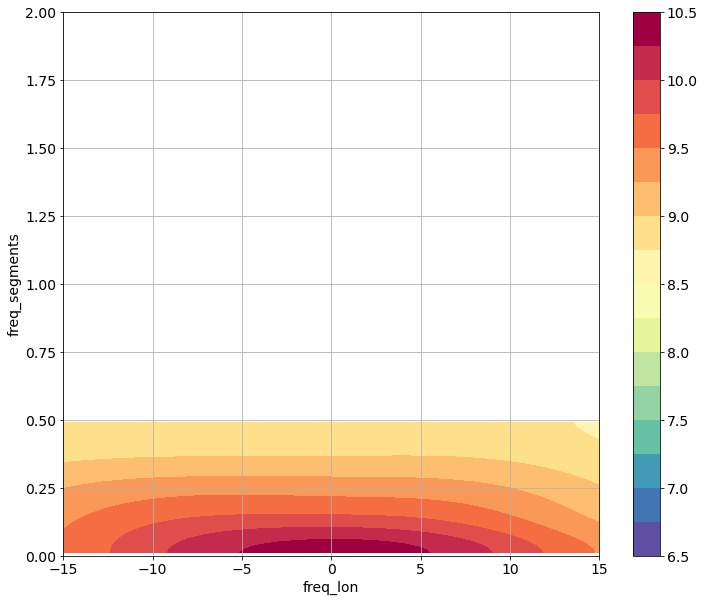

In [16]:
background = smooth_wavefreq(z2avg, kern=simple_smooth_kernel(), nsmooth=50, freq_name='freq_segments')
background
test = background
test.loc[{'freq_segments':0}] = np.nan

_tcwvhat = xu.log10(test) 

_tcwvhat.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,2], xlim =[-15,15], levels = 20,
                       cmap='Spectral_r')
plt.grid()

In [17]:
# separate components
z2_sym = z_final[0]
z2_asy = z_final[1]

# normalize
nspec_sym = z2_sym / background 
nspec_asy = z2_asy / background
nspec_sym['freq_lon'] = wavenumber
nspec_asy['freq_lon'] = wavenumber

# nspec_sym['freq_segments'] = spd * nspec_sym['freq_segments']
# nspec_asy['freq_segments'] = spd * nspec_asy['freq_segments']
# nspec_sym = np.flip(nspec_sym.values , axis = 0)
    #

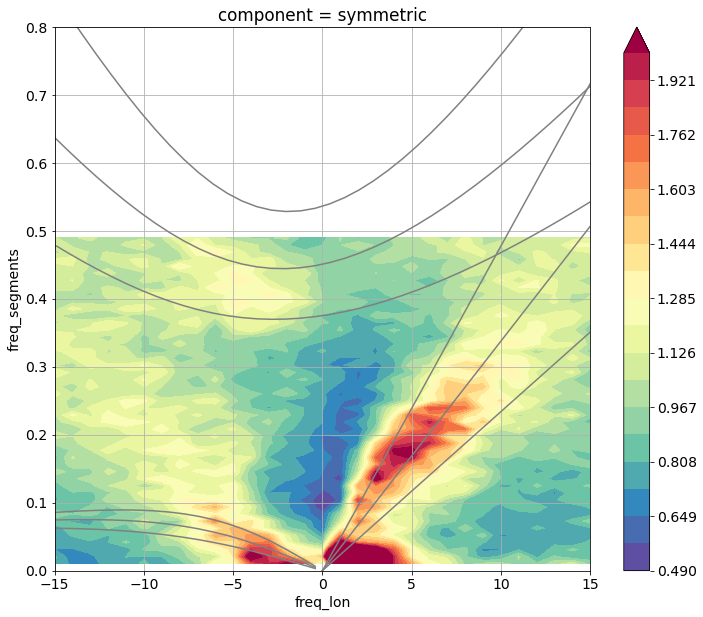

In [18]:
plt.figure()
nspec_sym.plot.contourf(x='freq_lon', y = 'freq_segments', ylim = [-0,0.8], xlim =[-15,15], levels = 20, vmax=2,
                       cmap='Spectral_r')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
plt.grid()
plt.show()

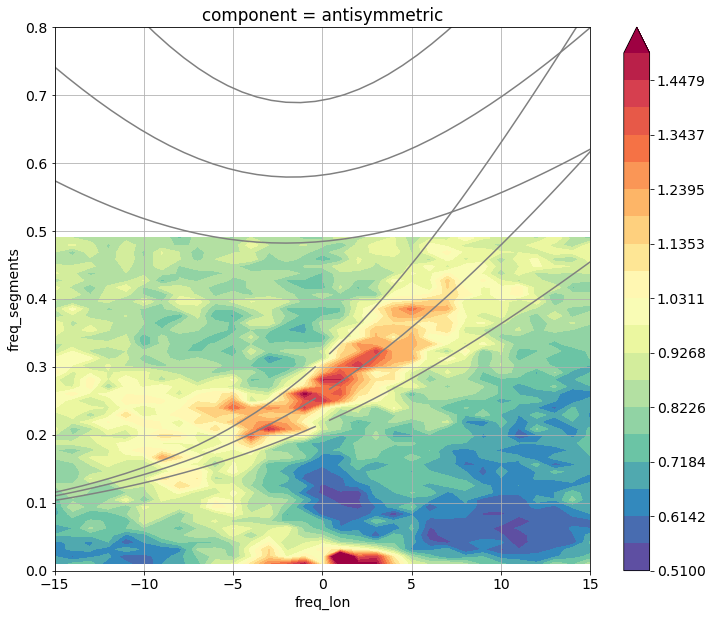

In [19]:
plt.figure()
nspec_asy.plot.contourf(x='freq_lon', y = 'freq_segments', levels = 20,xlim =[-15,15], ylim = [-0,0.8], vmax= 1.5,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
plt.grid()
plt.show()

In [20]:
nspec_tot = nspec_sym + nspec_asy

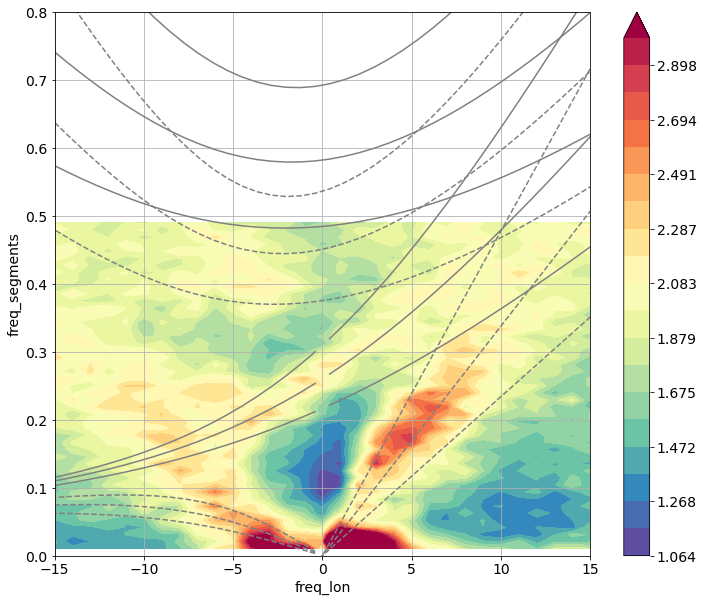

In [21]:
plt.figure()
nspec_tot.plot.contourf(x='freq_lon', y = 'freq_segments', levels = 20,xlim =[-15,15], ylim = [-0,0.8], vmax= 3,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()

In [22]:
def kelvinfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None, rlat = 0):
    """kelvin wave filter
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number
       'hmin/hmax' --equivalent depth
    """
    """
    Function to derive the shallow water dispersion curves. Closely follows NCL version.
    input:
        nWaveType : integer, number of wave types to do
        nPlanetaryWave: integer
        rlat: latitude in radians (just one latitude, usually 0.0)
        Ahe: [50.,25.,12.] equivalent depths
              ==> defines parameter: nEquivDepth ; integer, number of equivalent depths to do == len(Ahe)
    returns: tuple of size 2
        Afreq: Frequency, shape is (nWaveType, nEquivDepth, nPlanetaryWave)
        Apzwn: Zonal savenumber, shape is (nWaveType, nEquivDepth, nPlanetaryWave)
        
    notes:
        The outputs contain both symmetric and antisymmetric waves. In the case of 
        nWaveType == 6:
        0,1,2 are (ASYMMETRIC) "MRG", "IG", "EIG" (mixed rossby gravity, inertial gravity, equatorial inertial gravity)
        3,4,5 are (SYMMETRIC) "Kelvin", "ER", "IG" (Kelvin, equatorial rossby, inertial gravity)
    """
    pi    = np.pi
    radius = 6.37122e06    # [m]   average radius of earth
    g     = 9.80665        # [m/s] gravity at 45 deg lat used by the WMO
    omega = 7.292e-05      # [1/s] earth's angular vel
    ll    = 2.*pi*radius*np.cos(np.abs(rlat))
    Beta  = 2.*omega*np.cos(np.abs(rlat))/radius
    fillval = 1e20
    
    knum = da.freq_lon
    freq = da.freq_time
#     nf, nlat, nk = da.shape

    # filtering ############################################################
    mask = da
    #wavenumber cut-off
    if kmin != None:
        mask = mask.where((da.freq_lon > kmin) & (da.freq_lon < kmax), drop = True)
    
    #frequency cutoff
    if fmin != None:
        mask = mask.where((da.freq_time > fmin) & (da.freq_time < fmax), drop = True)

    #dispersion filter
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c) #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)         #adusting wavenumber to m
        mask = mask.where(lambda da: omega - k >= 0.)
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c) #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum+1)) * np.sqrt(c/Beta)         #adusting wavenumber to m
        mask = mask.where(lambda da: omega - k <= 0.)

    tcwvhat = mask

#     filterd = xrft.ifft(tcwvhat, dim = ['freq_time','freq_lon'], 
#                                   true_phase=False, true_amplitude=True) # Signal in direct space

    return tcwvhat

In [23]:
def erfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None, n=1, rlat = 0):
    """equatorial wave filter
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number
       'hmin/hmax' -- equivalent depth
       'n'         -- meridional mode number
    """

    if n <=0 or n%1 !=0:
        print ("n must be n>=1 integer")
        sys.exit()

    knum = da.freq_lon
    freq = da.freq_time

    # filtering ############################################################
    mask = da
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum+1)) * np.sqrt(c/Beta)                          #adusting ^2pia to ^m               
        mask = mask.where(lambda da: omega*(k**2 + (2*n+1)) + k >= 0.)   
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)   
        mask = mask.where(lambda da: omega*(k**2 + (2*n+1)) + k <= 0.)             

    tcwvhat = mask

#     filterd = xrft.ifft(tcwvhat, dim = ['freq_time','freq_lon'], 
#                                   true_phase=False, true_amplitude=True) # Signal in direct space

    return tcwvhat

In [24]:
rlat = 0
pi    = np.pi
radius = 6.37122e06    # [m]   average radius of earth
g     = 9.80665        # [m/s] gravity at 45 deg lat used by the WMO
omega = 7.292e-05      # [1/s] earth's angular vel
ll    = 2.*pi*radius*np.cos(np.abs(rlat))
Beta  = 2.*omega*np.cos(np.abs(rlat))/radius
fillval = 1e20

def mrgfilter(da, fmin=None, fmax=None, kmin=None, hmin=None, hmax=None):
    """mixed Rossby gravity wave
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number. negative is westward, positive is
                      eastward
       'hmin/hmax' -- equivalent depth
    """
    
    knum = da.freq_lon
    freq = da.freq_time
    #dispersion filter
    mask = da
    mask = mask.where((da.freq_lon <= -1.), drop = True)
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)                         #adusting ^2pia to ^m               
        mask = mask.where(lambda da: (omega**2 - k*omega - 1) >= 0.) 
    if hmax != None:
        c = np.sqrt(g*hmax)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum+1)) * np.sqrt(c/Beta)                 #adusting ^2pia to ^m               
        mask = mask.where(lambda da: (omega**2 - k*omega - 1) <= 0.) 
  
    tcwvhat = mask

#     filterd = xrft.ifft(tcwvhat, dim = ['freq_time','freq_lon'], 
#                                   true_phase=False, true_amplitude=True) # Signal in direct space

    return tcwvhat

In [25]:
def igfilter(da, fmin=None, fmax=None, kmin=None, kmax=None, hmin=None, hmax=None, n=1):
    """n>=1 inertio gravirt wave filter. default is n=1 WIG.
    Arguments:
       'fmin/fmax' -- unit is cycle per day
       'kmin/kmax' -- zonal wave number. negative is westward, positive is
                      eastward
       'hmin/hmax' -- equivalent depth
       'n'         -- meridional mode number
    """

    knum = da.freq_lon
    freq = da.freq_time
    #dispersion filter
    mask = da
    if hmin != None:
        c = np.sqrt(g*hmin)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)                   #adusting ^2pia to ^m               
        mask = mask.where(lambda da: (omega**2 - k**2 - (2*n+1)  < 0) >= 0.) 
    if hmax != None:
        c = np.sqrt(g*hmin)
        omega = 2.*pi*freq/24./3600. / np.sqrt(Beta*c)           #adusting day^-1 to s^-1
        k     = 1/((radius)/(knum-1)) * np.sqrt(c/Beta)                      #adusting ^2pia to ^m               
        mask = mask.where(lambda da: (omega**2 - k**2 - (2*n+1)  < 0) <= 0.) 
    tcwvhat = mask

#     filterd = xrft.ifft(tcwvhat, dim = ['freq_time','freq_lon'], 
#                                   true_phase=False, true_amplitude=True) # Signal in direct space

    return tcwvhat

In [26]:
_ds = ds['OLR_ano'].sel(lat = slice(-15.1,15.1))
_ds

x_wintap = _ds.chunk({"time" : -1, "lat": 1})
x_wintap
tcwvhat = xrft.fft(x_wintap, detrend='linear',
            dim=['time','lon'], true_phase=False, true_amplitude=True)

tcwvhat


<xarray.DataArray 'rechunk-merge-cf20d4f1c3c0d6c4ca59bcce8b4a2bfd' (freq_time: 6939, lat: 30, freq_lon: 360)>
dask.array<mul, shape=(6939, 30, 360), dtype=complex128, chunksize=(6939, 1, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 -14.5 -13.5 -12.5 -11.5 ... 11.5 12.5 13.5 14.5
  * freq_time  (freq_time) float64 -5.786e-06 -5.785e-06 ... 5.785e-06 5.786e-06
  * freq_lon   (freq_lon) float64 -0.5 -0.4972 -0.4944 ... 0.4917 0.4944 0.4972

In [27]:
_tcwvhat = tcwvhat.copy()
ppp = (_tcwvhat*xu.conj(_tcwvhat)).real
ppp = ppp.persist()
ppp = ppp.sum('lat')
ppp = smooth_wavefreq(ppp, kern=simple_smooth_kernel(), nsmooth=50, freq_name='freq_time')

ppp = xr.DataArray(np.flip(ppp.values , axis = 1),
                       dims=("freq_time","freq_lon"), 
                       coords={
                             "freq_time":ppp.freq_time,
                             "freq_lon":ppp.freq_lon})
ppp.name = 'power'
ppp
# # # ppp = ppp/background
# # # ppp


<xarray.DataArray 'power' (freq_time: 6939, freq_lon: 360)>
array([[3.54913173e+18, 3.55307231e+18, 3.56098537e+18, ...,
        3.63748597e+18, 3.63569764e+18, 3.63489155e+18],
       [3.55526595e+18, 3.55874019e+18, 3.56578850e+18, ...,
        3.63196025e+18, 3.62947268e+18, 3.62828781e+18],
       [3.56623440e+18, 3.56886716e+18, 3.57435351e+18, ...,
        3.62185556e+18, 3.61809127e+18, 3.61621615e+18],
       ...,
       [3.70235298e+18, 3.69974020e+18, 3.69545469e+18, ...,
        3.51066043e+18, 3.49999526e+18, 3.49447390e+18],
       [3.71709117e+18, 3.71353848e+18, 3.70754118e+18, ...,
        3.50041363e+18, 3.48836683e+18, 3.48211957e+18],
       [3.72493569e+18, 3.72088379e+18, 3.71397850e+18, ...,
        3.49486606e+18, 3.48207390e+18, 3.47543499e+18]])
Coordinates:
  * freq_time  (freq_time) float64 -5.786e-06 -5.785e-06 ... 5.785e-06 5.786e-06
  * freq_lon   (freq_lon) float64 -0.5 -0.4972 -0.4944 ... 0.4917 0.4944 0.4972

In [28]:
#Cell to create dispersion curve
swfreq,swwn = genDispersionCurves()
# swfreq.shape # -->(6, 3, 50)
swf = np.where(swfreq == 1e20, np.nan, swfreq)
swk = np.where(swwn == 1e20, np.nan, swwn)

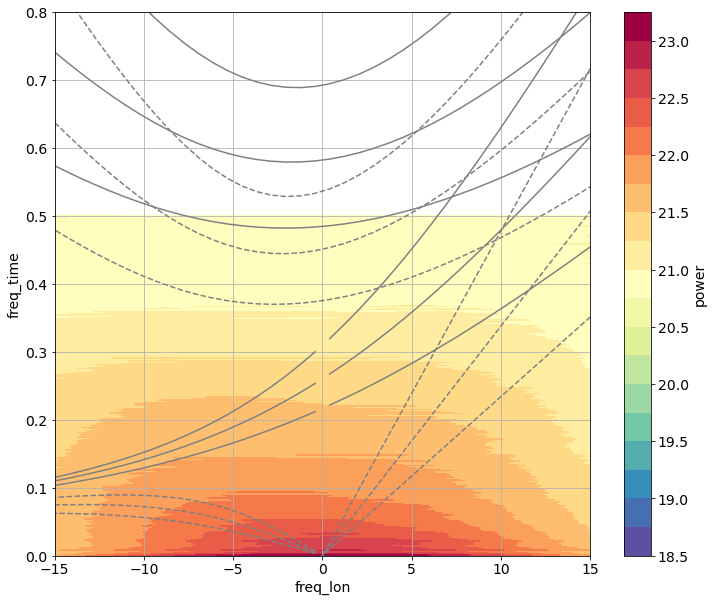

In [29]:
_ppp = ppp.copy()
_ppp['freq_time'] = _ppp['freq_time']*(86400)

_ppp.loc[{'freq_time':0}] = np.nan

_ppp = xu.log10(_ppp) 

wavenumber = np.zeros(_ppp.freq_lon.size)
for i in range( _ppp.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i]= _ppp.freq_lon[int(360/2)+j]*360 + 1
    
_ppp['freq_lon'] = wavenumber

plt.figure()
_ppp.plot.contourf(x='freq_lon', y = 'freq_time', levels = 20,xlim =[-15,15], ylim = [-0,0.8],
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()

In [30]:
nIndex = int(_ppp.freq_time.size/2) 
1/_ppp['freq_time'][0]*(86400)

<xarray.DataArray 'freq_time' ()>
array(-172824.90631306)
Coordinates:
    freq_time  float64 -0.4999

In [31]:
_tcwvhat = tcwvhat.copy()


wavenumber = np.zeros(_tcwvhat.freq_lon.size)
for i in range( _tcwvhat.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i]= _tcwvhat.freq_lon[int(360/2)+j]*360 + 1
    
_tcwvhat['freq_lon'] = wavenumber
_tcwvhat['freq_time'] = _tcwvhat['freq_time']*(86400)

_tcwvhat
_tcwvhat = (_tcwvhat*xu.conj(_tcwvhat)).real
_tcwvhat = _tcwvhat.sum('lat')
_tcwvhat = smooth_wavefreq(_tcwvhat, kern=simple_smooth_kernel(), nsmooth=50, freq_name='freq_time')

_tcwvhat = xu.log10(_tcwvhat) 

_dahat = kelvinfilter(_tcwvhat, fmin=0, fmax=0.25, kmin=0, kmax=5)
_dahat

<xarray.DataArray (freq_time: 1734, freq_lon: 4)>
array([[23.24081704, 23.22616982, 23.19622316, 23.15104987],
       [23.23993145, 23.22482956, 23.19442049, 23.14879677],
       [23.23788078, 23.22195908, 23.19071314, 23.14427191],
       ...,
       [21.4159555 , 21.42852317, 21.44007595, 21.44997433],
       [21.41421673, 21.42692778, 21.43854365, 21.44840314],
       [21.41195898, 21.4243787 , 21.43564801, 21.44511317]])
Coordinates:
  * freq_time  (freq_time) float64 0.0001441 0.0002882 ... 0.2497 0.2499
  * freq_lon   (freq_lon) float64 1.0 2.0 3.0 4.0

In [32]:
_dahat

<xarray.DataArray (freq_time: 1734, freq_lon: 4)>
array([[23.24081704, 23.22616982, 23.19622316, 23.15104987],
       [23.23993145, 23.22482956, 23.19442049, 23.14879677],
       [23.23788078, 23.22195908, 23.19071314, 23.14427191],
       ...,
       [21.4159555 , 21.42852317, 21.44007595, 21.44997433],
       [21.41421673, 21.42692778, 21.43854365, 21.44840314],
       [21.41195898, 21.4243787 , 21.43564801, 21.44511317]])
Coordinates:
  * freq_time  (freq_time) float64 0.0001441 0.0002882 ... 0.2497 0.2499
  * freq_lon   (freq_lon) float64 1.0 2.0 3.0 4.0

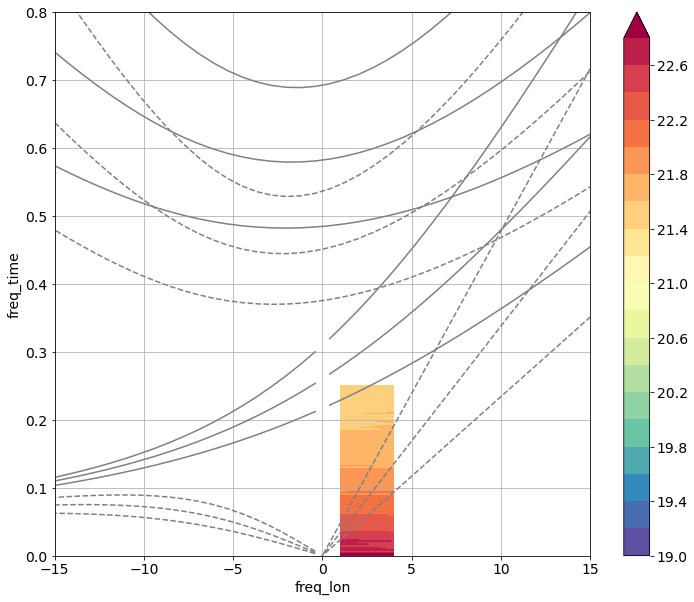

In [33]:
plt.figure()
_dahat.plot.contourf(x='freq_lon', y = 'freq_time', ylim = [-0,0.8], xlim =[-15,15], 
                     levels = 20, vmin = 19., vmax = 22.8,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()

In [ ]:
_tcwvhat = tcwvhat.copy()


wavenumber = np.zeros(_tcwvhat.freq_lon.size)
for i in range( _tcwvhat.freq_lon.size):
    j= - int(360/2) + i
    wavenumber[i]= _tcwvhat.freq_lon[int(360/2)+j]*360 + 1
    
_tcwvhat['freq_lon'] = wavenumber
_tcwvhat['freq_time'] = _tcwvhat['freq_time']*(86400)

_tcwvhat
_tcwvhat = (_tcwvhat*xu.conj(_tcwvhat)).real
_tcwvhat = _tcwvhat.sum('lat')
_tcwvhat = smooth_wavefreq(_tcwvhat, kern=simple_smooth_kernel(), nsmooth=50, freq_name='freq_time')

_tcwvhat = xu.log10(_tcwvhat) 

__dahat = kelvinfilter(_tcwvhat, hmin=12, hmax=50)
__dahat

In [ ]:

plt.figure()
__dahat.plot.contourf(x='freq_lon', y = 'freq_time', ylim = [-0,0.8], xlim =[-15,15], 
                     levels = 20, vmin = 19., vmax = 22.8,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()

In [ ]:
__dahat = erfilter(_tcwvhat, hmin=12, hmax=50)


In [ ]:

plt.figure()
__dahat.plot.contourf(x='freq_lon', y = 'freq_time', ylim = [-0,0.8], xlim =[-15,15], 
                     levels = 20, vmin = 19., vmax = 22.8,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()

In [ ]:
__dahat = mrgfilter(_tcwvhat, hmin=12, hmax=50)

plt.figure()
__dahat.plot.contourf(x='freq_lon', y = 'freq_time', ylim = [-0,0.8], xlim =[-15,15], 
                     levels = 20, vmin = 19., vmax = 22.8,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()

In [ ]:
__dahat = igfilter(_tcwvhat, hmin=12, hmax=50)

plt.figure()
__dahat.plot.contourf(x='freq_lon', y = 'freq_time', ylim = [-0,0.8], xlim =[-15,15], 
                     levels = 20, vmin = 19., vmax = 22.8,
                       cmap='Spectral_r')
for ii in range(0,3):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey')
for ii in range(3,6):
    plt.plot(swk[ii, 0,:], swf[ii,0,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 1,:], swf[ii,1,:], color='grey', linestyle='dashed')
    plt.plot(swk[ii, 2,:], swf[ii,2,:], color='grey', linestyle='dashed')
plt.grid()
plt.show()